# RUL prediction Exponential Model


In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score

from scipy import optimize

#### Prépare les données pour l'entraînement et le test d'un modèle de prédiction de RUL.


In [2]:
def prepare_data(feature_selection = True):
    dependent_var = ['RUL']
    column_names = ['engine', 'time', 'op_setting_1', 'op_setting_2', 
                'op_setting_3'] + [f'sm_{i}' for i in range(1, 22)]

    # voire la partie feature selection 
    #les features selectionnées
    features  = ['op_setting_1', 'op_setting_2',"sm_2", "sm_3", "sm_4", "sm_7", "sm_8",
             "sm_9", "sm_11" , "sm_12", "sm_13",  "sm_15", "sm_17", "sm_20", "sm_21"
            ]

    train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
    train_data.columns=column_names
    
    max = pd.DataFrame(train_data.groupby('engine')['time'].max()).reset_index()
    max.columns = ['engine', 'max']
    train_data = train_data.merge(max, on=['engine'], how='left')
    train_data['RUL'] = train_data['max'] - train_data['time']
    train_data.drop('max', axis=1, inplace=True)

    test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
    
    if(feature_selection == True):
        train_data = train_data[['engine', 'time' ]+features+['RUL']]
        test_data = test_data[['engine', 'time' ]+features]

    test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    test_rul["engine"] = test_rul.index +1
    
    return train_data, test_data, test_rul

#### Prétraitement des données

In [3]:
train_data, test_data, test_rul = prepare_data()


C:\Users\user\AppData\Local\Temp\ipykernel_35136\4194414081.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_35136\4194414081.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
C:\Users\user\AppData\Local\Temp\ipykernel_35136\4194414081.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


In [4]:
features = train_data.columns.drop(['engine', 'time', 'RUL'])

#### Normalisation des caractéristiques.
normaliser les caractéristiques sélectionnées (features) dans l'intervalle [−1,1]

In [5]:
sc = MinMaxScaler(feature_range=(-1,1))

train_data[features] = sc.fit_transform(train_data[features])
test_data[features] = sc.transform(test_data[features])

df_train=train_data
df_test=test_data

In [6]:
train_data.head()

,engine,time,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190
1,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189
2,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188
3,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187
4,1,6,-0.494253,-0.166667,-0.463855,-0.414432,-0.455773,0.552335,-0.636364,-0.749170,-0.630952,0.275053,-0.558824,-0.338977,-0.500000,0.302326,0.305440,186


In [7]:
df_test.head()

,engine,time,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


#### utiliser La moyenne glissante pour réduire le bruit

In [8]:
df_train_mean = df_train.groupby('engine')[features].rolling(window = 5).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)



df_test_mean = df_test.groupby('engine')[features].rolling(window = 5).mean()
df_test_mean = df_test_mean.reset_index()
df_test_mean.dropna(inplace = True)
df_test_mean.drop(['level_1'], axis = 1, inplace = True)

df_train_mean.head()

,engine,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
4,1,-0.181609,-0.100000,-0.365060,-0.348419,-0.307562,0.409340,-0.509091,-0.743929,-0.504762,0.533475,-0.500000,-0.332820,-0.400000,0.243411,0.348799
5,1,-0.202299,0.033333,-0.325301,-0.344059,-0.343822,0.447343,-0.521212,-0.716899,-0.535714,0.536887,-0.523529,-0.385764,-0.400000,0.274419,0.323281
6,1,-0.181609,0.033333,-0.300000,-0.387922,-0.365631,0.420934,-0.569697,-0.738688,-0.542857,0.541151,-0.523529,-0.401462,-0.366667,0.280620,0.304722
7,1,-0.179310,0.066667,-0.327711,-0.316503,-0.413369,0.371981,-0.606061,-0.744108,-0.504762,0.449893,-0.541176,-0.394382,-0.366667,0.333333,0.322784
8,1,-0.211494,0.166667,-0.407229,-0.243340,-0.452262,0.345572,-0.612121,-0.750301,-0.564286,0.415778,-0.529412,-0.395614,-0.366667,0.348837,0.358685


#### selection des colonnes avec monotonicité élevée 

In [9]:
# Définition de la fonction de calcul de la monotonicité
def monotonicity(data):
    
    num_pos = data[data > 0].shape[0]  # Nombre de différences positives
    num_neg = data[data < 0].shape[0]  # Nombre de différences négatives
    tot_n = data.shape[0] - 1          # Total des points de données - 1
    mon_val = np.abs(num_pos - num_neg) / tot_n
    return mon_val

<Axes: xlabel='monotonicity', ylabel='column'>

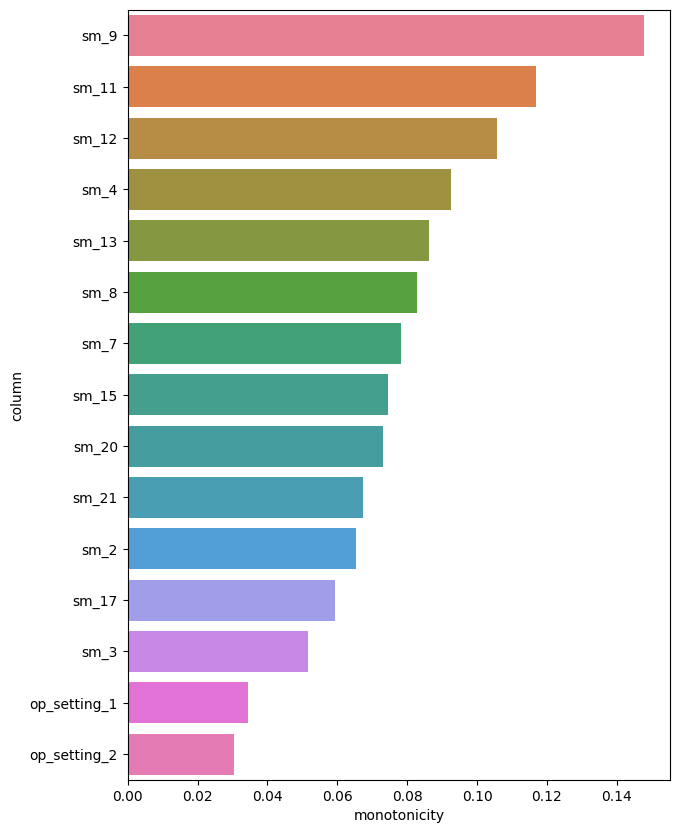

In [10]:
mon_df = []

# Parcours des colonnes pour calculer la monotonicité
for col in features:
    motor_mon_values = []  # Liste des monotonicités par moteur

    # Parcours des moteurs (engine)
    for motor_id, motor_data in df_train_mean.groupby('engine'):
        diff_data = motor_data[col].diff().dropna()  # Différences lag
        mon_value = monotonicity(diff_data)         # Calcul de la monotonicité
        motor_mon_values.append(mon_value)

    # Moyenne des monotonicités pour chaque colonne
    avg_mon_value = np.mean(motor_mon_values)
    mon_df.append({"column": col, "monotonicity": avg_mon_value})
    
# Conversion en DataFrame pandas
mon_df = pd.DataFrame(mon_df)
mon_df=mon_df.sort_values(by = 'monotonicity', ascending = False)

fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.column, x = mon_df.monotonicity,hue=mon_df.column)


In [11]:
feats = mon_df.column[mon_df.monotonicity > 0.055]
feats

7      sm_9
8     sm_11
9     sm_12
4      sm_4
10    sm_13
6      sm_8
5      sm_7
11    sm_15
13    sm_20
14    sm_21
2      sm_2
12    sm_17
Name: column, dtype: object

#### Application de PCA pour fusionner les caractéristiques

In [12]:
from sklearn.decomposition import PCA



In [13]:
pca = PCA(n_components=3)

# Transformation des données avec PCA
pca_data = pca.fit_transform(df_train_mean[feats])

# Création d'un DataFrame pour stocker les composantes principales
pca_df = pd.DataFrame(pca_data, columns=['pc1', 'pc2', 'pc3'])
pca_df['engine'] = df_train_mean.engine.values
pca_df['time'] = pca_df.groupby('engine').cumcount() + 1
pca_df['RUL'] = pca_df.groupby('engine').time.transform('max') - pca_df.time

pca_df.head()

,pc1,pc2,pc3,engine,time,RUL
0,-0.807269,-0.101203,-0.008391,1,1,186
1,-0.855270,-0.067058,0.046910,1,2,185
2,-0.855764,-0.065667,0.070193,1,3,184
3,-0.849531,-0.073329,0.051534,1,4,183
4,-0.902863,-0.096924,-0.010732,1,5,182


#### Visualisation des Composantes Principales

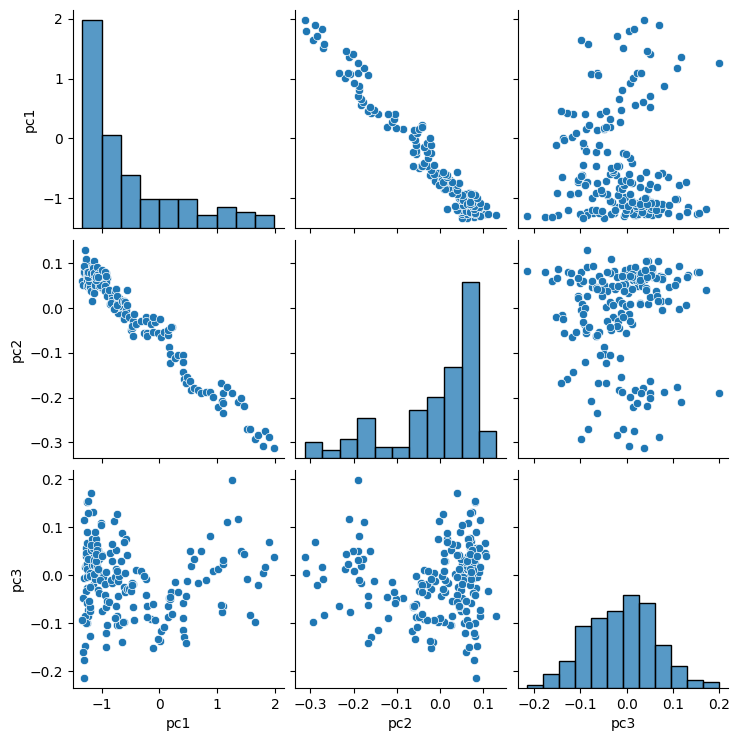

In [14]:
import seaborn as sns

# Définir les noms des composantes principales
pcs = ['pc1', 'pc2', 'pc3']

# Création d'un pairplot pour explorer les relations entre les PCs
sns.pairplot(data=pca_df[pca_df.engine == 30], x_vars=pcs, y_vars=pcs)


#### Visualiser la relation entre les deux premières composantes principales (pc1 et pc2) en fonction de RUL

<Axes: xlabel='pc1', ylabel='pc2'>

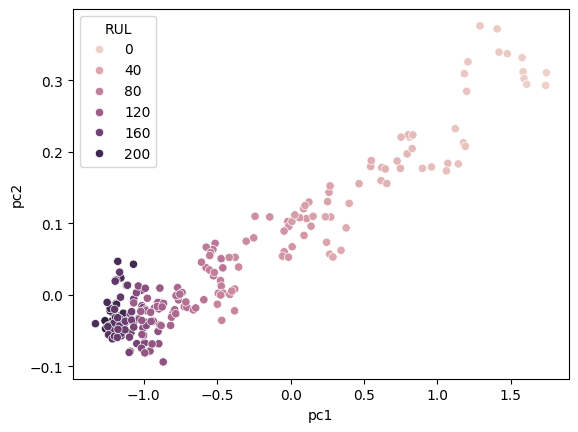

In [15]:
sns.scatterplot(data = pca_df[pca_df.engine == 10], x = "pc1", y = "pc2", hue = "RUL")

#### on prendre  la première composante principale (PC1) comme un indicateur de santé 

##### Visualisation de PC1 en tant qu'indicateur de santé

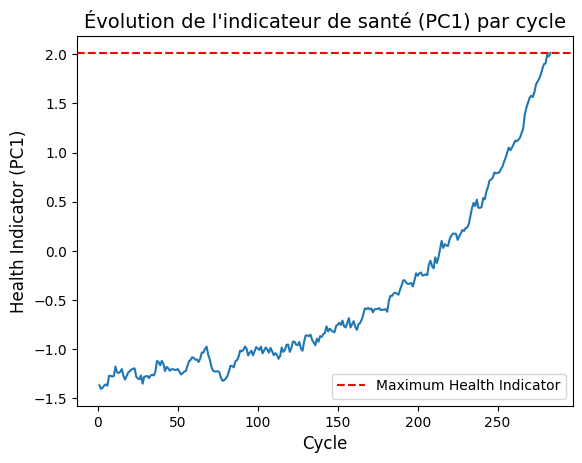

In [16]:
# Création d'un graphique de ligne
fig, ax = plt.subplots()
sns.lineplot(data=pca_df[pca_df.engine == 2], x="time", y="pc1", ax=ax)

# Ajout d'une ligne horizontale représentant le maximum de PC1
plt.axhline(pca_df[pca_df.engine == 2].pc1.max(), color='r', linestyle='--', label='Maximum Health Indicator')

# Ajout de labels et d'un titre
ax.set_xlabel("Cycle", fontsize=12)
ax.set_ylabel("Health Indicator (PC1)", fontsize=12)
plt.title("Évolution de l'indicateur de santé (PC1) par cycle", fontsize=14)
plt.legend()
plt.show()


#### visualisation des indicateurs de santé de plusieurs  moteurs


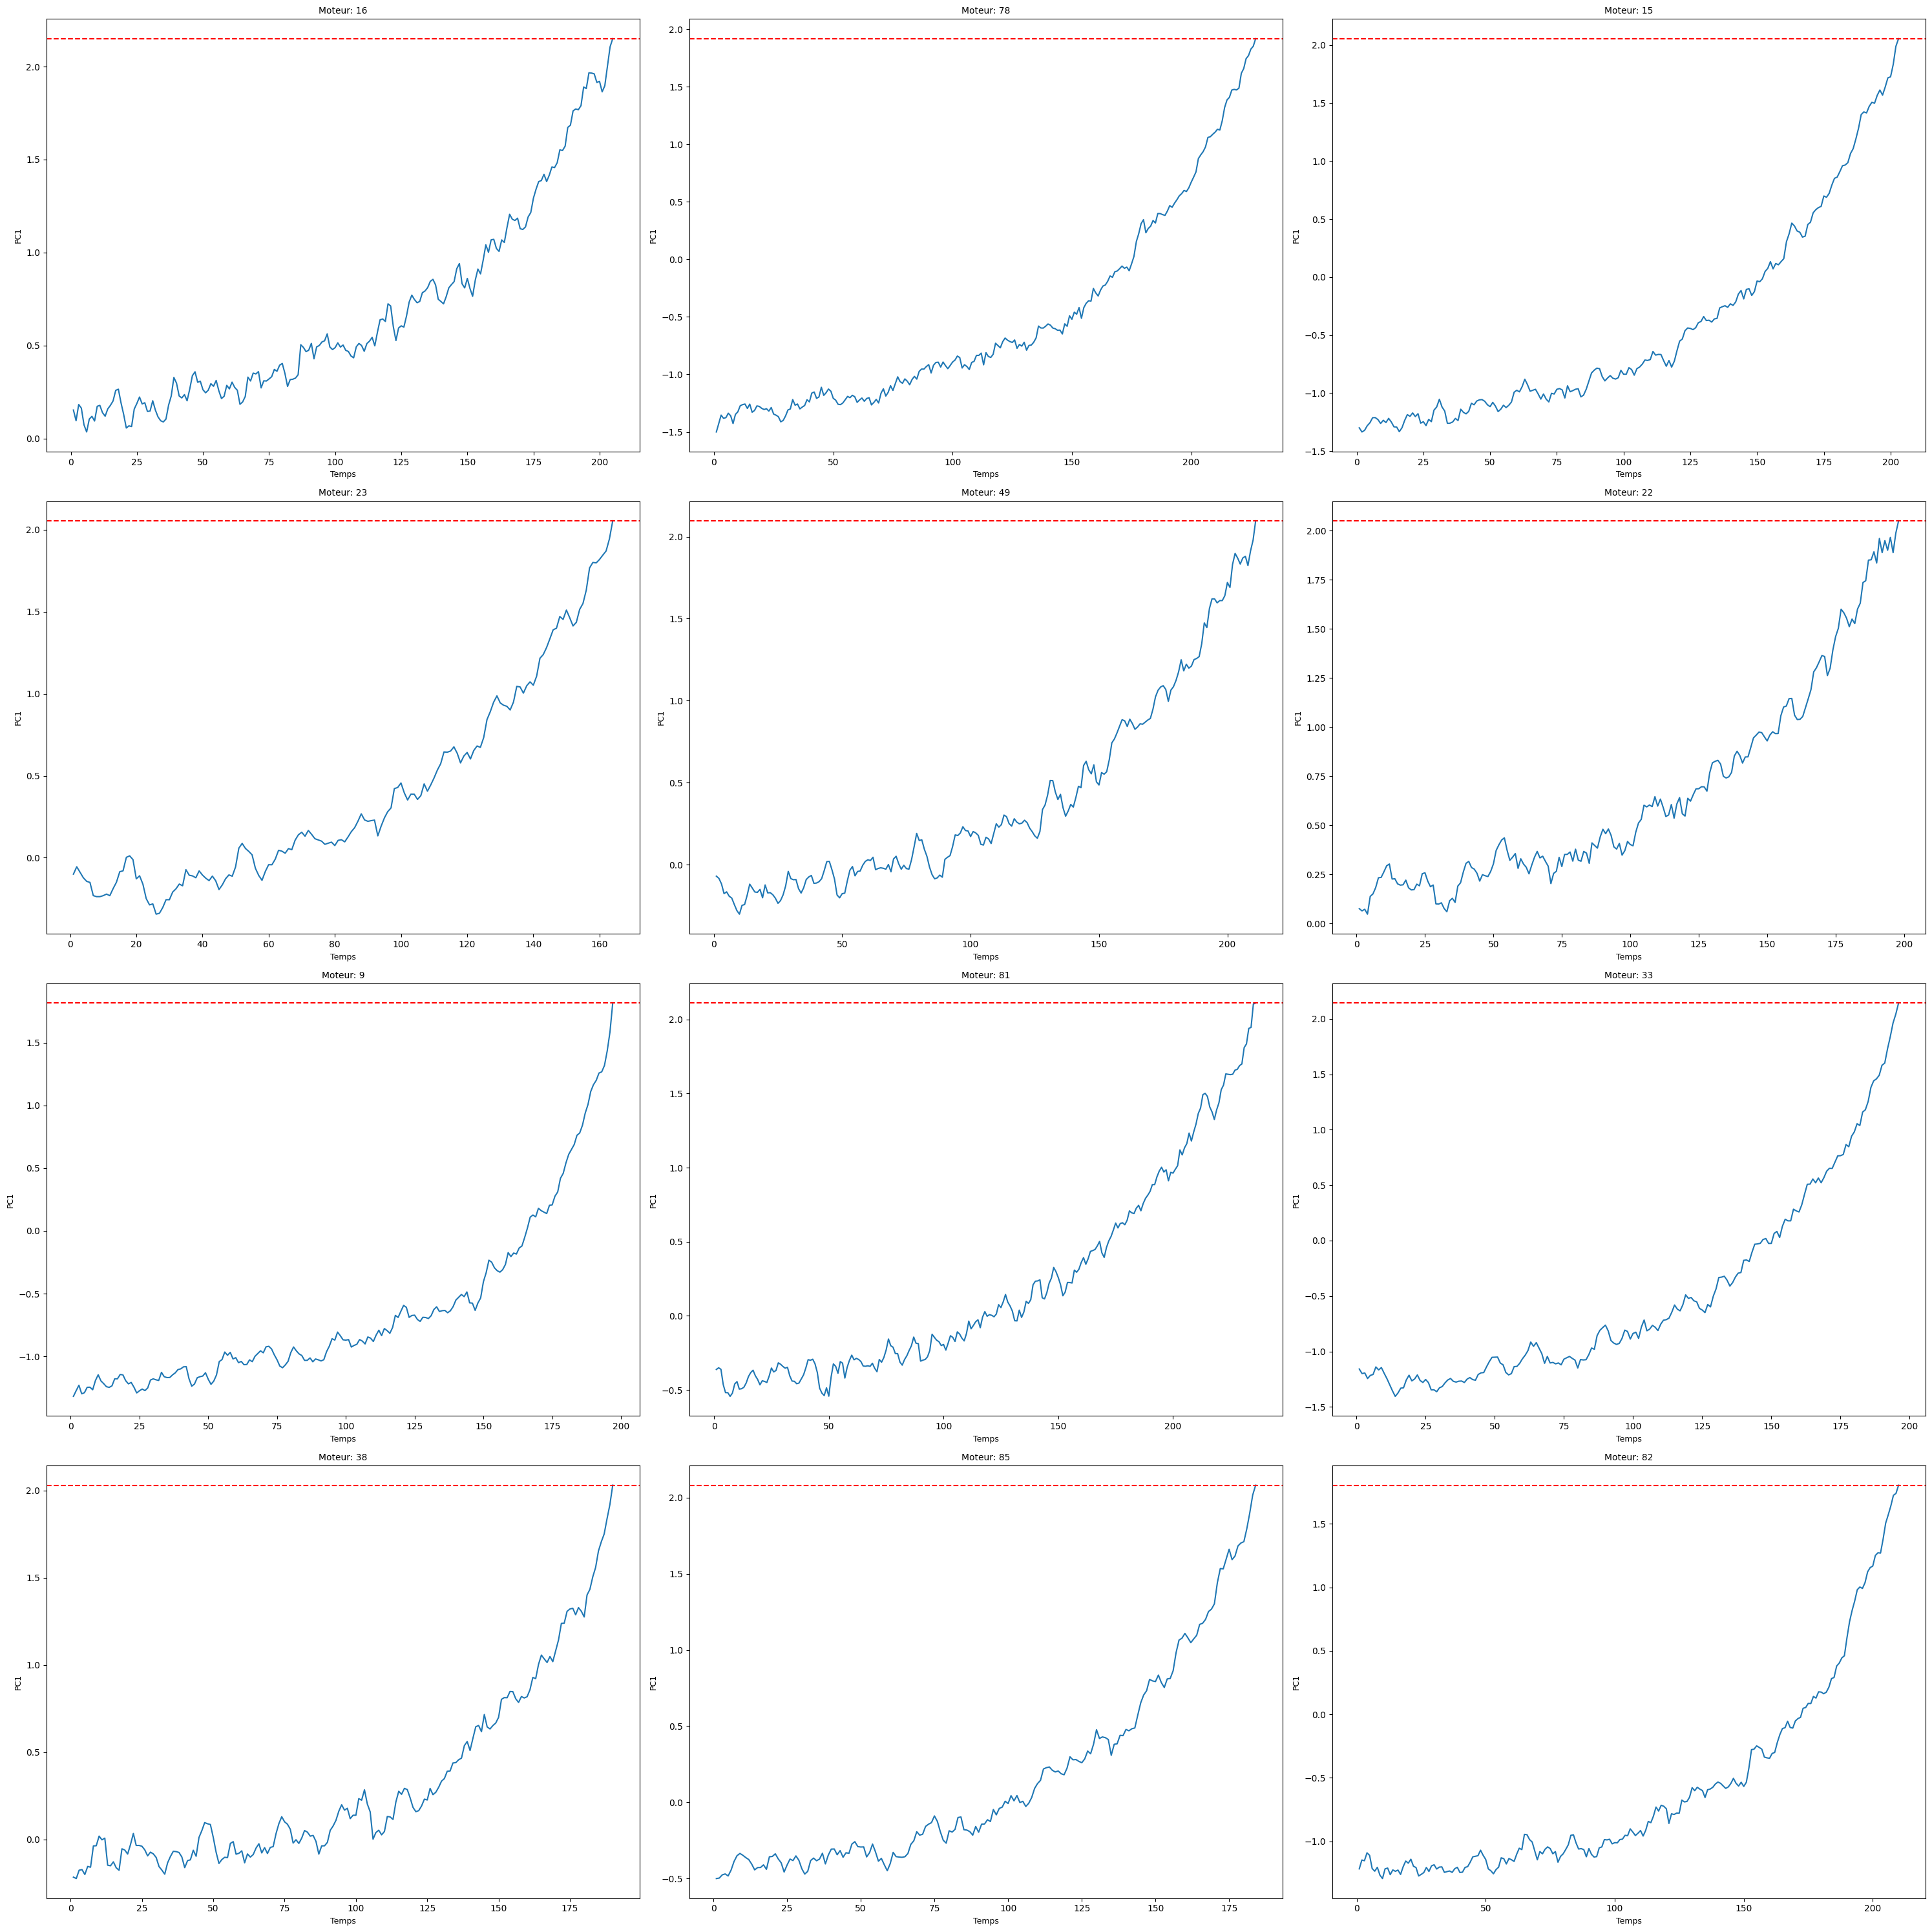

In [17]:
import random

# Sélection de 10 moteurs aléatoires
random_engines = random.sample(range(1, 101), 12)

# Création de sous-graphiques (2 lignes, 5 colonnes pour 10 moteurs)
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))
ax = ax.ravel()

# Tracer les courbes pour les moteurs sélectionnés
for i, engine in enumerate(random_engines):
    sns.lineplot(data=pca_df[pca_df.engine == engine], x="time", y="pc1", ax=ax[i])
    ax[i].axhline(pca_df[pca_df.engine == engine].pc1.max(), color='r', linestyle='--')
    ax[i].set_title(f"Moteur: {engine}", fontsize=10)
    ax[i].set_xlabel("Temps", fontsize=9)
    ax[i].set_ylabel("PC1", fontsize=9)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


### Visualisation des valeurs des indicateurs de santé selon différentes règles

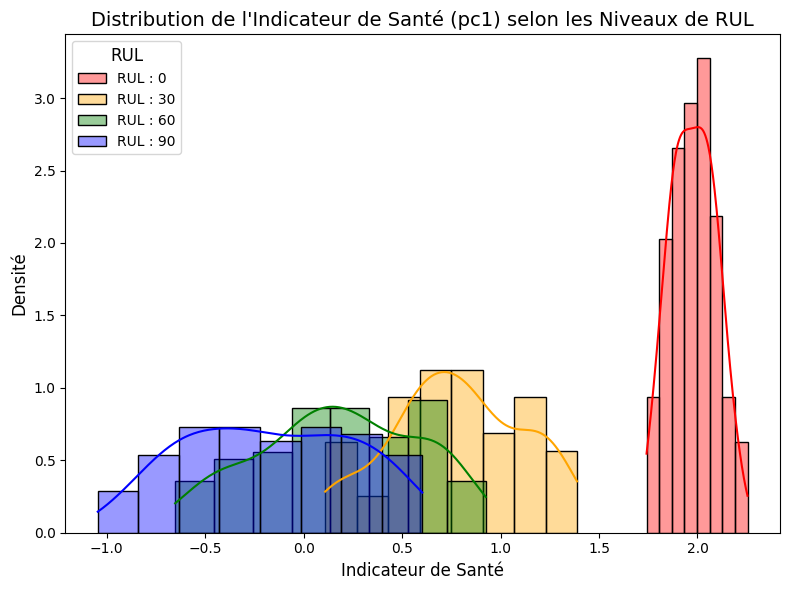

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les distributions pour différentes valeurs de RUL
sns.histplot(pca_df.pc1[pca_df.RUL == 0], label="RUL : 0", ax=ax, kde=True, color="red", stat="density", alpha=0.4)
sns.histplot(pca_df.pc1[pca_df.RUL == 30], label="RUL : 30", ax=ax, kde=True, color="orange", stat="density", alpha=0.4)
sns.histplot(pca_df.pc1[pca_df.RUL == 60], label="RUL : 60", ax=ax, kde=True, color="green", stat="density", alpha=0.4)
sns.histplot(pca_df.pc1[pca_df.RUL == 90], label="RUL : 90", ax=ax, kde=True, color="b", stat="density", alpha=0.4)

# Ajouter les étiquettes et la légende
ax.set_xlabel("Indicateur de Santé", fontsize=12)
ax.set_ylabel("Densité", fontsize=12)
ax.legend(title="RUL", fontsize=10, title_fontsize=12)
ax.set_title("Distribution de l'Indicateur de Santé (pc1) selon les Niveaux de RUL", fontsize=14)

# Affichage
plt.tight_layout()
plt.show()


#### Comme nous pouvons le constater, la dispersion diminue avec la diminution du RUL

#### Seuil de défaillance :
En prenant la valeur moyenne de l'indicateur de santé lorsque RUL = 0 comme seuil de défaillance

In [19]:
threshold = pca_df.pc1[pca_df.RUL == 0].mean()
threshold

np.float64(1.9783738830959066)

##### Et l'écart-type associé 

In [20]:
threshold_std = pca_df.pc1[pca_df.RUL == 0].std()
threshold_std


np.float64(0.11473057437392947)

## Modèle de l'Indicateur de Santé (Exponentiel)

Dans cette section, nous appliquons un modèle exponentiel pour modéliser l'évolution de l'**indicateur de santé** (HI) au fil du temps pour chaque moteur. Le modèle utilisé est :


\begin{equation*}
HI(t) = A + B \cdot e^{\lambda t}
\end{equation*}

Où :
- \( A \) : Valeur de l'indicateur de santé à \( t = 0 \).
- \( B \) : Amplitude du déclin de l'indicateur de santé.
- \( \lambda \) : Taux de dégradation exponentielle (constante).

L'objectif est d'ajuster ce modèle pour chaque moteur en fonction de ses données de cycle et d'indicateur de santé \( pc1 \), et de trouver les paramètres \( A \), \( B \), et \( \lambda \) qui minimisent l'erreur entre les valeurs observées et le modèle.





In [21]:

def exp_degradation(parameters, cycle):
    '''
    Calculate an exponential degradation of the form:
    ht = phi + theta * exp(beta * cycle)
   
    '''
    phi = parameters[0]   # Initial value of the health indicator
    theta = parameters[1] # Amplitude of degradation
    beta = parameters[2]  # Rate of exponential degradation
    
    # Calculate the health indicator value at each cycle
    ht = phi + theta * np.exp(beta * cycle)
    return ht


In [22]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    - y_predicted = func(parameters, data)
    - y_observed: observed data (the real values)
   
    '''
    # Calculate predicted values using the model function
    y_predicted = func(parameters, data)
    
    # Return the residuals (difference between predicted and observed values)
    return y_predicted - y_observed


In [23]:
param_0 = [-1, 0.01, 0.01]

In [24]:
exp_params_df = pd.DataFrame(columns=['engine', 'A', 'B', 'lambda_'])

for i in range(1,101):
    
    ht = pca_df.pc1[pca_df.engine == i]
    cycle = pca_df.time[pca_df.engine == i]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    A, B, lambda_ = OptimizeResult.x
    exp_params_df = pd.concat([exp_params_df, pd.DataFrame({'engine': [i], 'A': [A], 'B': [B], 'lambda_': [lambda_]})], ignore_index=True)


C:\Users\user\AppData\Local\Temp\ipykernel_35136\71255084.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exp_params_df = pd.concat([exp_params_df, pd.DataFrame({'engine': [i], 'A': [A], 'B': [B], 'lambda_': [lambda_]})], ignore_index=True)


In [25]:
exp_params_df.head()

,engine,A,B,lambda_
0,1,-0.880568,0.075135,0.019556
1,2,-1.337524,0.068601,0.013763
2,3,-0.937691,0.024805,0.026614
3,4,-0.516098,0.010315,0.029437
4,5,-1.283207,0.062999,0.014831


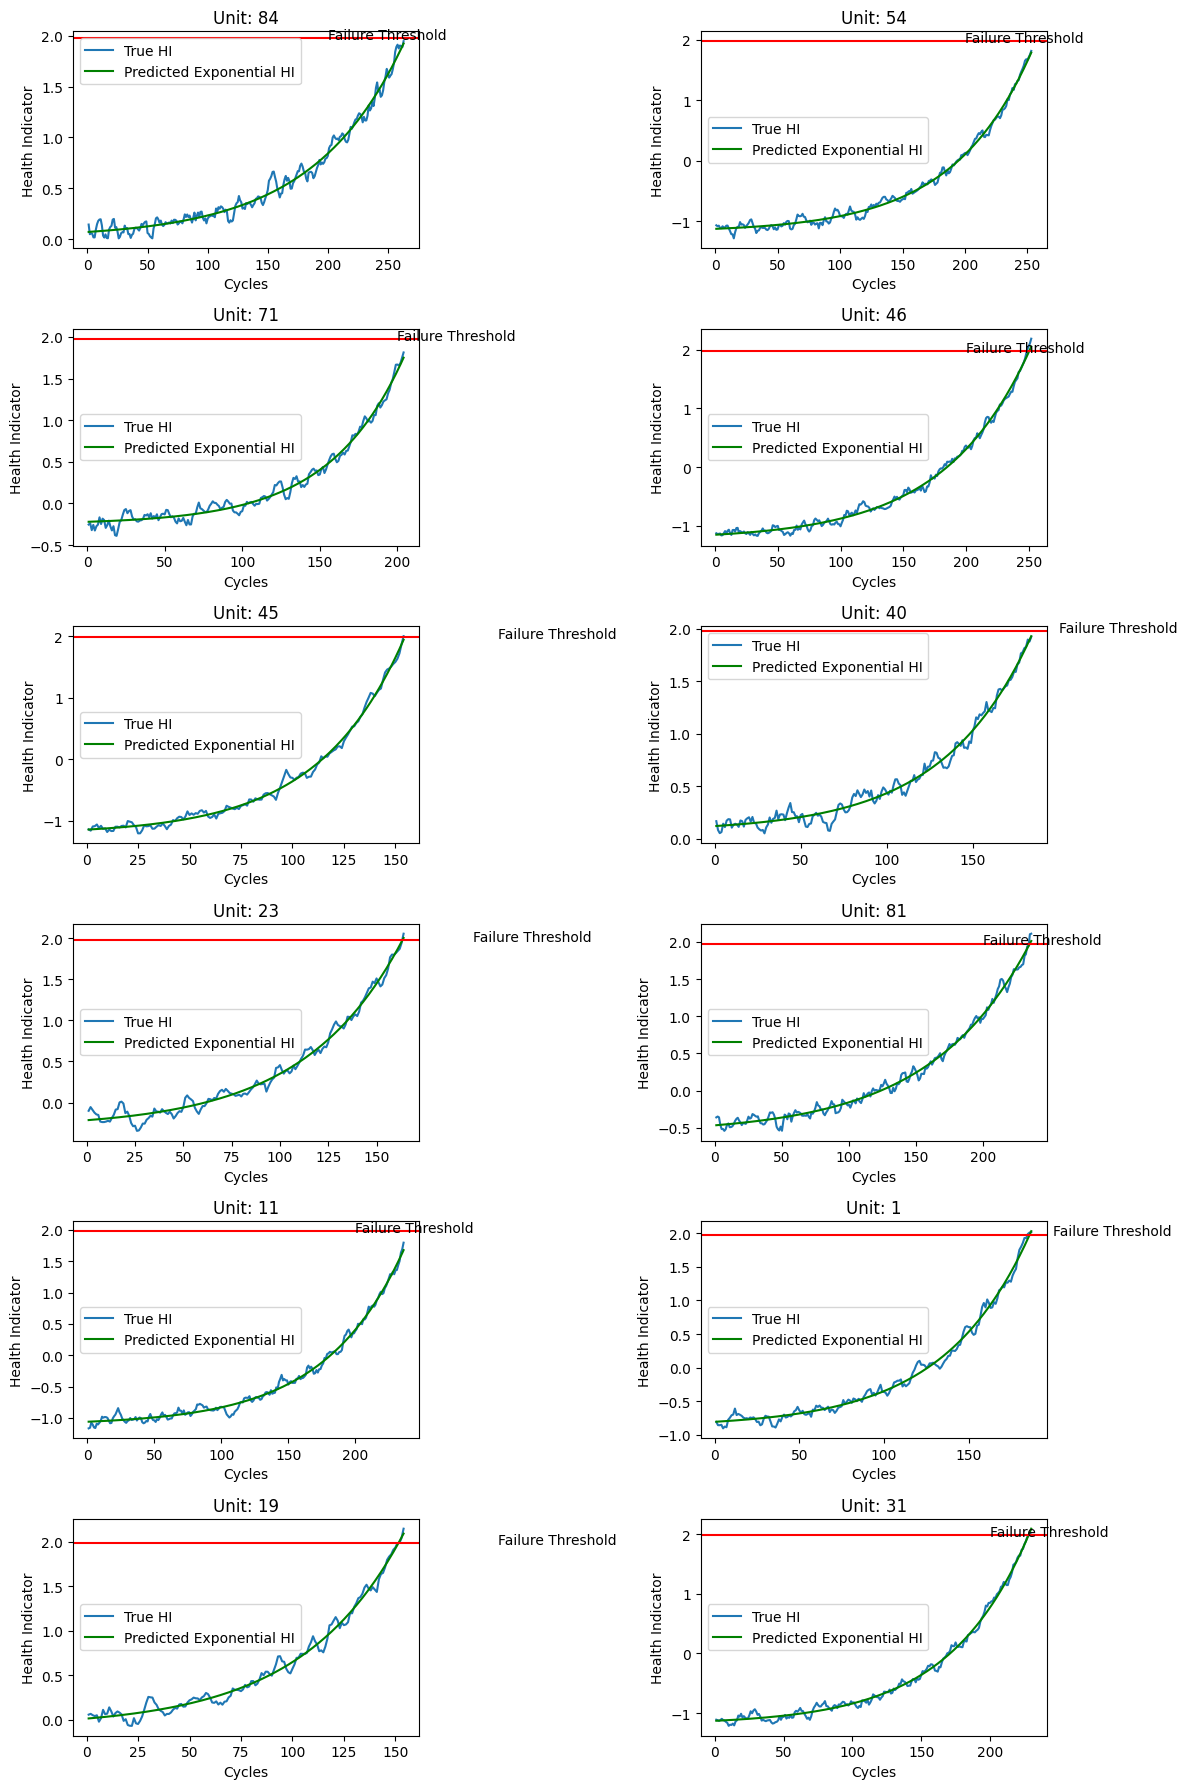

In [26]:
# Sélectionner 12 moteurs aléatoires
sample_engines = exp_params_df['engine'].sample(12, random_state=42).values

# Tracer pour chaque moteur
fig, axs = plt.subplots(6, 2, figsize=(12, 18))  # 6 lignes, 2 colonnes de sous-graphes
axs = axs.flatten()  # Pour faciliter l'accès aux sous-graphes

for i, engine_id in enumerate(sample_engines):
    ax = axs[i]  # Accéder à chaque sous-graphe
    # Récupérer les paramètres pour le moteur courant
    A = exp_params_df.A[exp_params_df.engine == engine_id].values[0]
    B = exp_params_df.B[exp_params_df.engine == engine_id].values[0]
    lambda_ = exp_params_df.lambda_[exp_params_df.engine == engine_id].values[0]

    # Récupérer les cycles et les données de l'indicateur de santé pour le moteur courant
    cycles = pca_df.time[pca_df.engine == engine_id]
    ht = pca_df.pc1[pca_df.engine == engine_id]

    # Calculer la dégradation ajustée pour ce moteur
    pred_ht = exp_degradation([A, B, lambda_], cycles)

    # Tracer les courbes de l'indicateur de santé
    sns.lineplot(data=pca_df[pca_df.engine == engine_id], x="time", y="pc1", ax=ax, label="True HI")
    sns.lineplot(y=pred_ht, x=cycles, ax=ax, color="green", label="Predicted Exponential HI")

    # Ajouter le seuil de défaillance
    ax.axhline(threshold, color='r')
    ax.text(200, threshold - 0.01, 'Failure Threshold', rotation=0)

    # Ajouter des titres et des labels
    ax.set_title(f"Unit: {engine_id}")
    ax.set_xlabel("Cycles")
    ax.set_ylabel("Health Indicator")
    ax.legend()

plt.tight_layout()
plt.show()


####  visualiser la distribution des paramètres A, B, et lambda 

<Axes: xlabel='lambda_', ylabel='Count'>

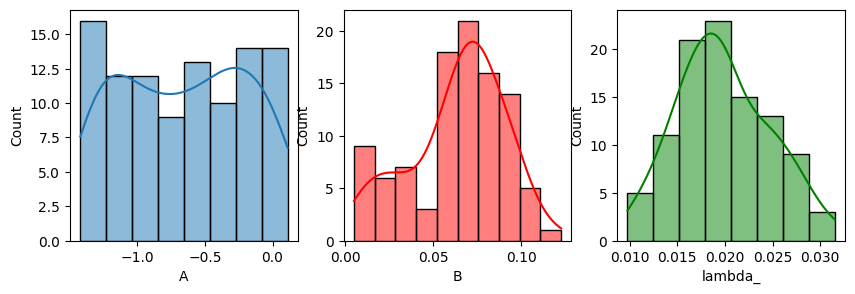

In [27]:
fig, ax = plt.subplots(figsize = (10,3), nrows = 1, ncols = 3)
sns.histplot(exp_params_df.A, ax = ax[0],kde=True)
sns.histplot(exp_params_df.B, ax = ax[1], color = "red",kde=True)
sns.histplot(exp_params_df.lambda_, ax = ax[2], color = "green",kde=True)

#### Préparation des données de test en calculant l'ACP pour l'ensemble de données de test

In [28]:
pca_test_data = pca.transform(df_test_mean[feats])

pca_test_df = pd.DataFrame(pca_test_data, columns = ['pc1', 'pc2', 'pc3'])
pca_test_df['engine'] = df_test_mean.engine.values
pca_test_df['time'] = pca_test_df.groupby('engine').cumcount()+1
pca_test_df.head()

,pc1,pc2,pc3,engine,time
0,-0.766636,-0.078035,0.103280,1,1
1,-0.803832,-0.081444,0.000534,1,2
2,-0.752349,-0.098227,0.030314,1,3
3,-0.757257,-0.108894,0.036194,1,4
4,-0.781999,-0.105622,-0.024830,1,5


##### Visualisation de PC1 (indicateur de santé) en fonction de temps


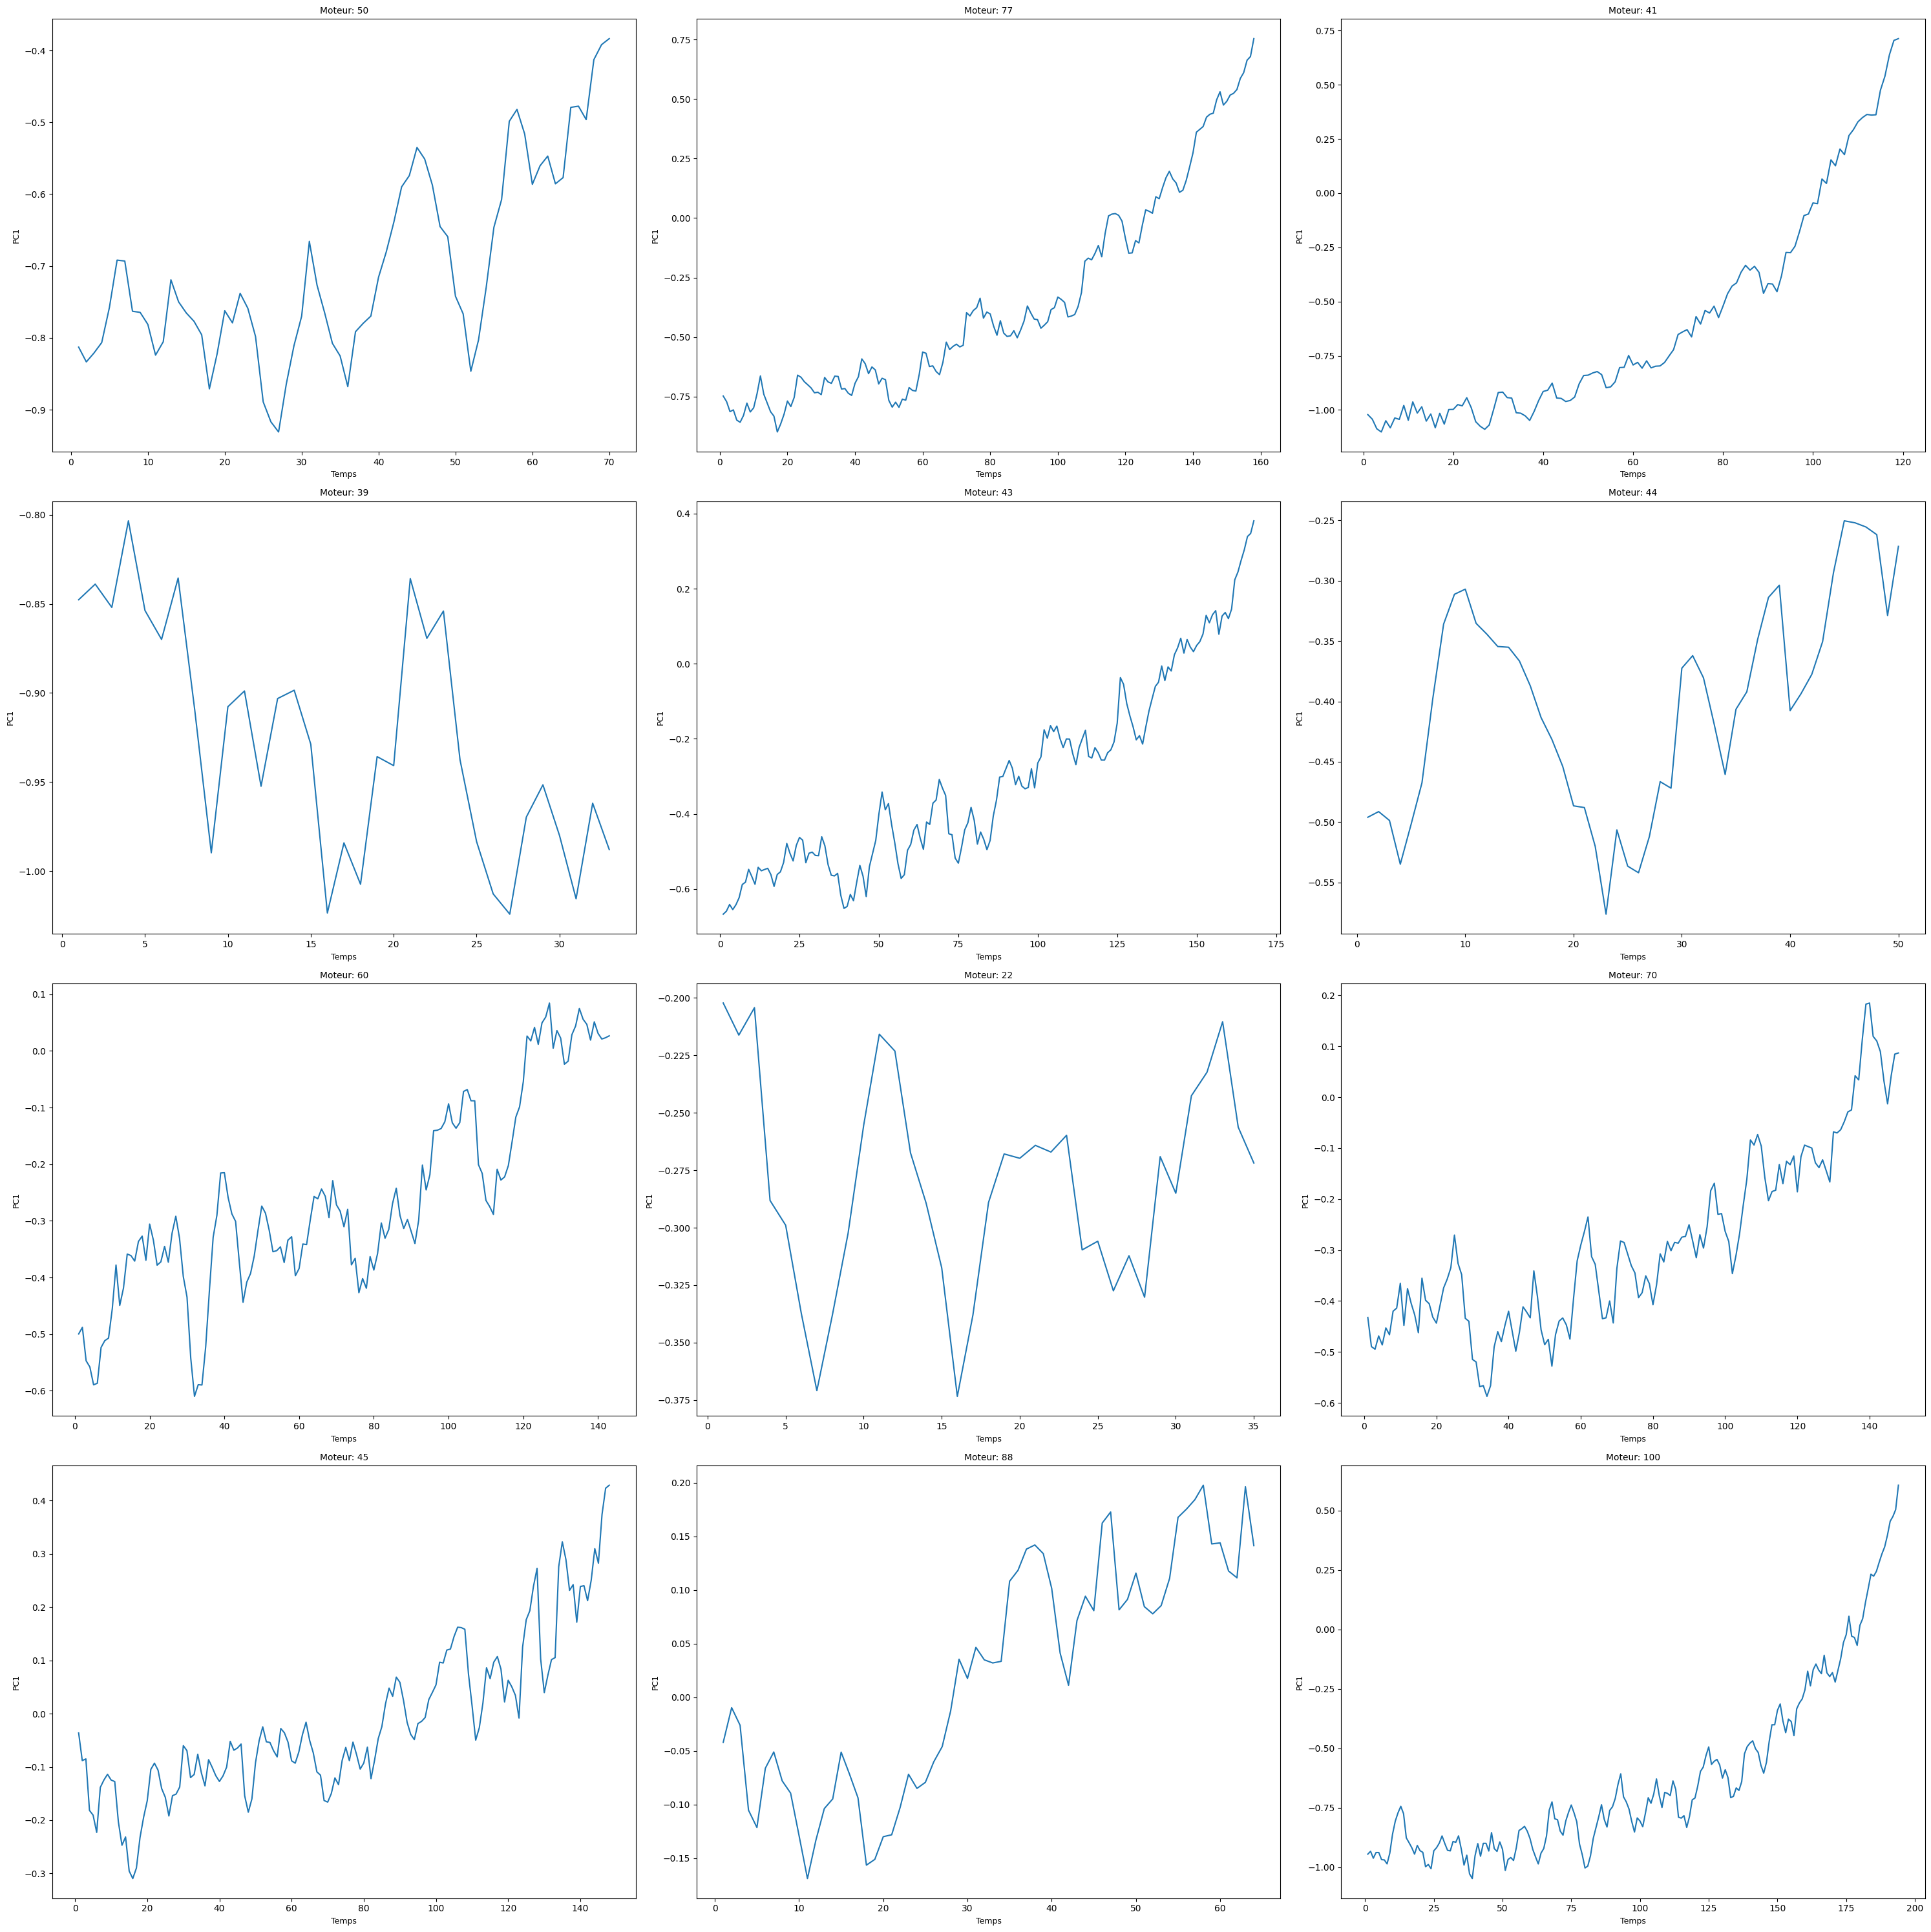

In [29]:
# Sélection de 12 moteurs de test aléatoires 
random_engines = random.sample(range(1, 101), 12)

# Création de sous-graphiques (2 lignes, 5 colonnes pour 10 moteurs)
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))
ax = ax.ravel()

# Tracer les courbes pour les moteurs sélectionnés
for i, engine in enumerate(random_engines):
    sns.lineplot(data=pca_test_df[pca_test_df.engine == engine], x="time", y="pc1", ax=ax[i])
    ax[i].set_title(f"Moteur: {engine}", fontsize=10)
    ax[i].set_xlabel("Temps", fontsize=9)
    ax[i].set_ylabel("PC1", fontsize=9)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


### Prédiction de la Durée de Vie Restante (RUL)

#### Étapes :

- **Ajuster un modèle exponentiel** sur les données de test en utilisant les paramètres comme valeurs moyennes, avec des bornes définies par les valeurs des 25e et 75e percentiles des modèles exponentiels obtenus à partir des données d'entraînement.

- **Calculer le nombre total de cycles** pour atteindre le seuil de défaillance.

- **Déterminer la Durée de Vie Restante (RUL)** :  
  \begin{equation*}
   RUL = t (\text{tel  que  l'indicateur de santé} = \text{seuil} ) - \text{temps actuel} 
   \end{equation*}
   

- **Répéter les étapes 1 à 3** pour toutes les unités de test.


In [30]:
A = exp_params_df.A
B = exp_params_df.B
lambda_ = exp_params_df.lambda_

param_1 = [A.mean(), B.mean(), lambda_.mean()]
param_1

[np.float64(-0.6614405435424119),
 np.float64(0.06387238274196616),
 np.float64(0.019820816233864974)]

In [31]:
lb = 25
ub = 75
A_bounds = [np.percentile(A, lb), np.percentile(A, ub)] 
B_bounds = [np.percentile(B, lb), np.percentile(B, ub)] 
lambda_bounds = [np.percentile(lambda_, lb), np.percentile(lambda_, ub)] 



bounds = ([A_bounds[0], B_bounds[0], lambda_bounds[0]], 
          [A_bounds[1], B_bounds[1], lambda_bounds[1]])
bounds

([np.float64(-1.1065702845261907),
  np.float64(0.05197703942557909),
  np.float64(0.01634532059649168)],
 [np.float64(-0.24996407166544626),
  np.float64(0.07997951324748219),
  np.float64(0.023413811540385028)])

#### Utilisation des moyennes et des bornes (25e et 75e percentiles)

Les paramètres du modèle exponentiel ajusté sur l'entraînement (A, B, λ) sont utilisés comme références pour guider l'ajustement sur les données de test.

#### Calcul des cycles totaux et de la RUL :

total_cycles représente le nombre de cycles nécessaires pour que l'indicateur de santé atteigne le seuil de défaillance (threshold).

- Utilise la relation exponentielle inversée pour trouver total_cycles :
\begin{equation}
\text{total\_cycles} = \frac{\log \left( \frac{\text{threshold} - A}{B} \right)}{\lambda}
\end{equation}

La RUL (Remaining Useful Life) est simplement la différence entre total_cycles et le cycle maximal observé dans les données (cycle.max()).

In [32]:
test_rul

,RUL,engine
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [33]:
result_test_df = pd.DataFrame(columns=['engine', 'A', 'B', 'lambda_', 'Pred_RUL', 'True_RUL'])

for i in pca_test_df.engine.unique():
    # Extraire les données pour l'unité actuelle
    ht = pca_test_df.pc1[pca_test_df.engine == i]
    cycle = pca_test_df.time[pca_test_df.engine == i]
    
    # Effectuer l'optimisation
    OptimizeResult = optimize.least_squares(
        residuals, param_1, bounds=bounds, args=(cycle, ht, exp_degradation)
    )
    
    # Extraire les paramètres ajustés
    A, B, lambda_ = OptimizeResult.x
    
    # Calculer le nombre total de cycles et la RUL
    total_cycles = np.log((threshold - A) / B) / lambda_
    RUL = total_cycles - cycle.max()
    
    # Ajouter une nouvelle ligne à result_test_df
    result_test_df = pd.concat([
        result_test_df,
        pd.DataFrame({
            'engine': [i],
            'A': [A],
            'B': [B],
            'lambda_': [lambda_],
            'Pred_RUL': [RUL],
            'True_RUL': [test_rul.RUL[test_rul.engine == i].values[0]]
        })
    ], ignore_index=True)


C:\Users\user\AppData\Local\Temp\ipykernel_35136\947618759.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_test_df = pd.concat([


In [34]:
result_test_df.head()

,engine,A,B,lambda_,Pred_RUL,True_RUL
0,1,-0.858803,0.079980,0.023414,125.422608,112
1,2,-0.303772,0.079980,0.023414,98.124962,98
2,3,-0.249964,0.079980,0.019196,51.332748,69
3,4,-0.364340,0.079980,0.019606,70.261633,82
4,5,-0.282076,0.054107,0.023406,65.458355,91


#### Results

In [35]:
t=np.float64(test_rul.RUL[test_rul['engine'] == 1].iloc[0])
exp_degradation([A, B, lambda_],t)

np.float64(-0.6876827628629618)

In [36]:
threshold

np.float64(1.9783738830959066)

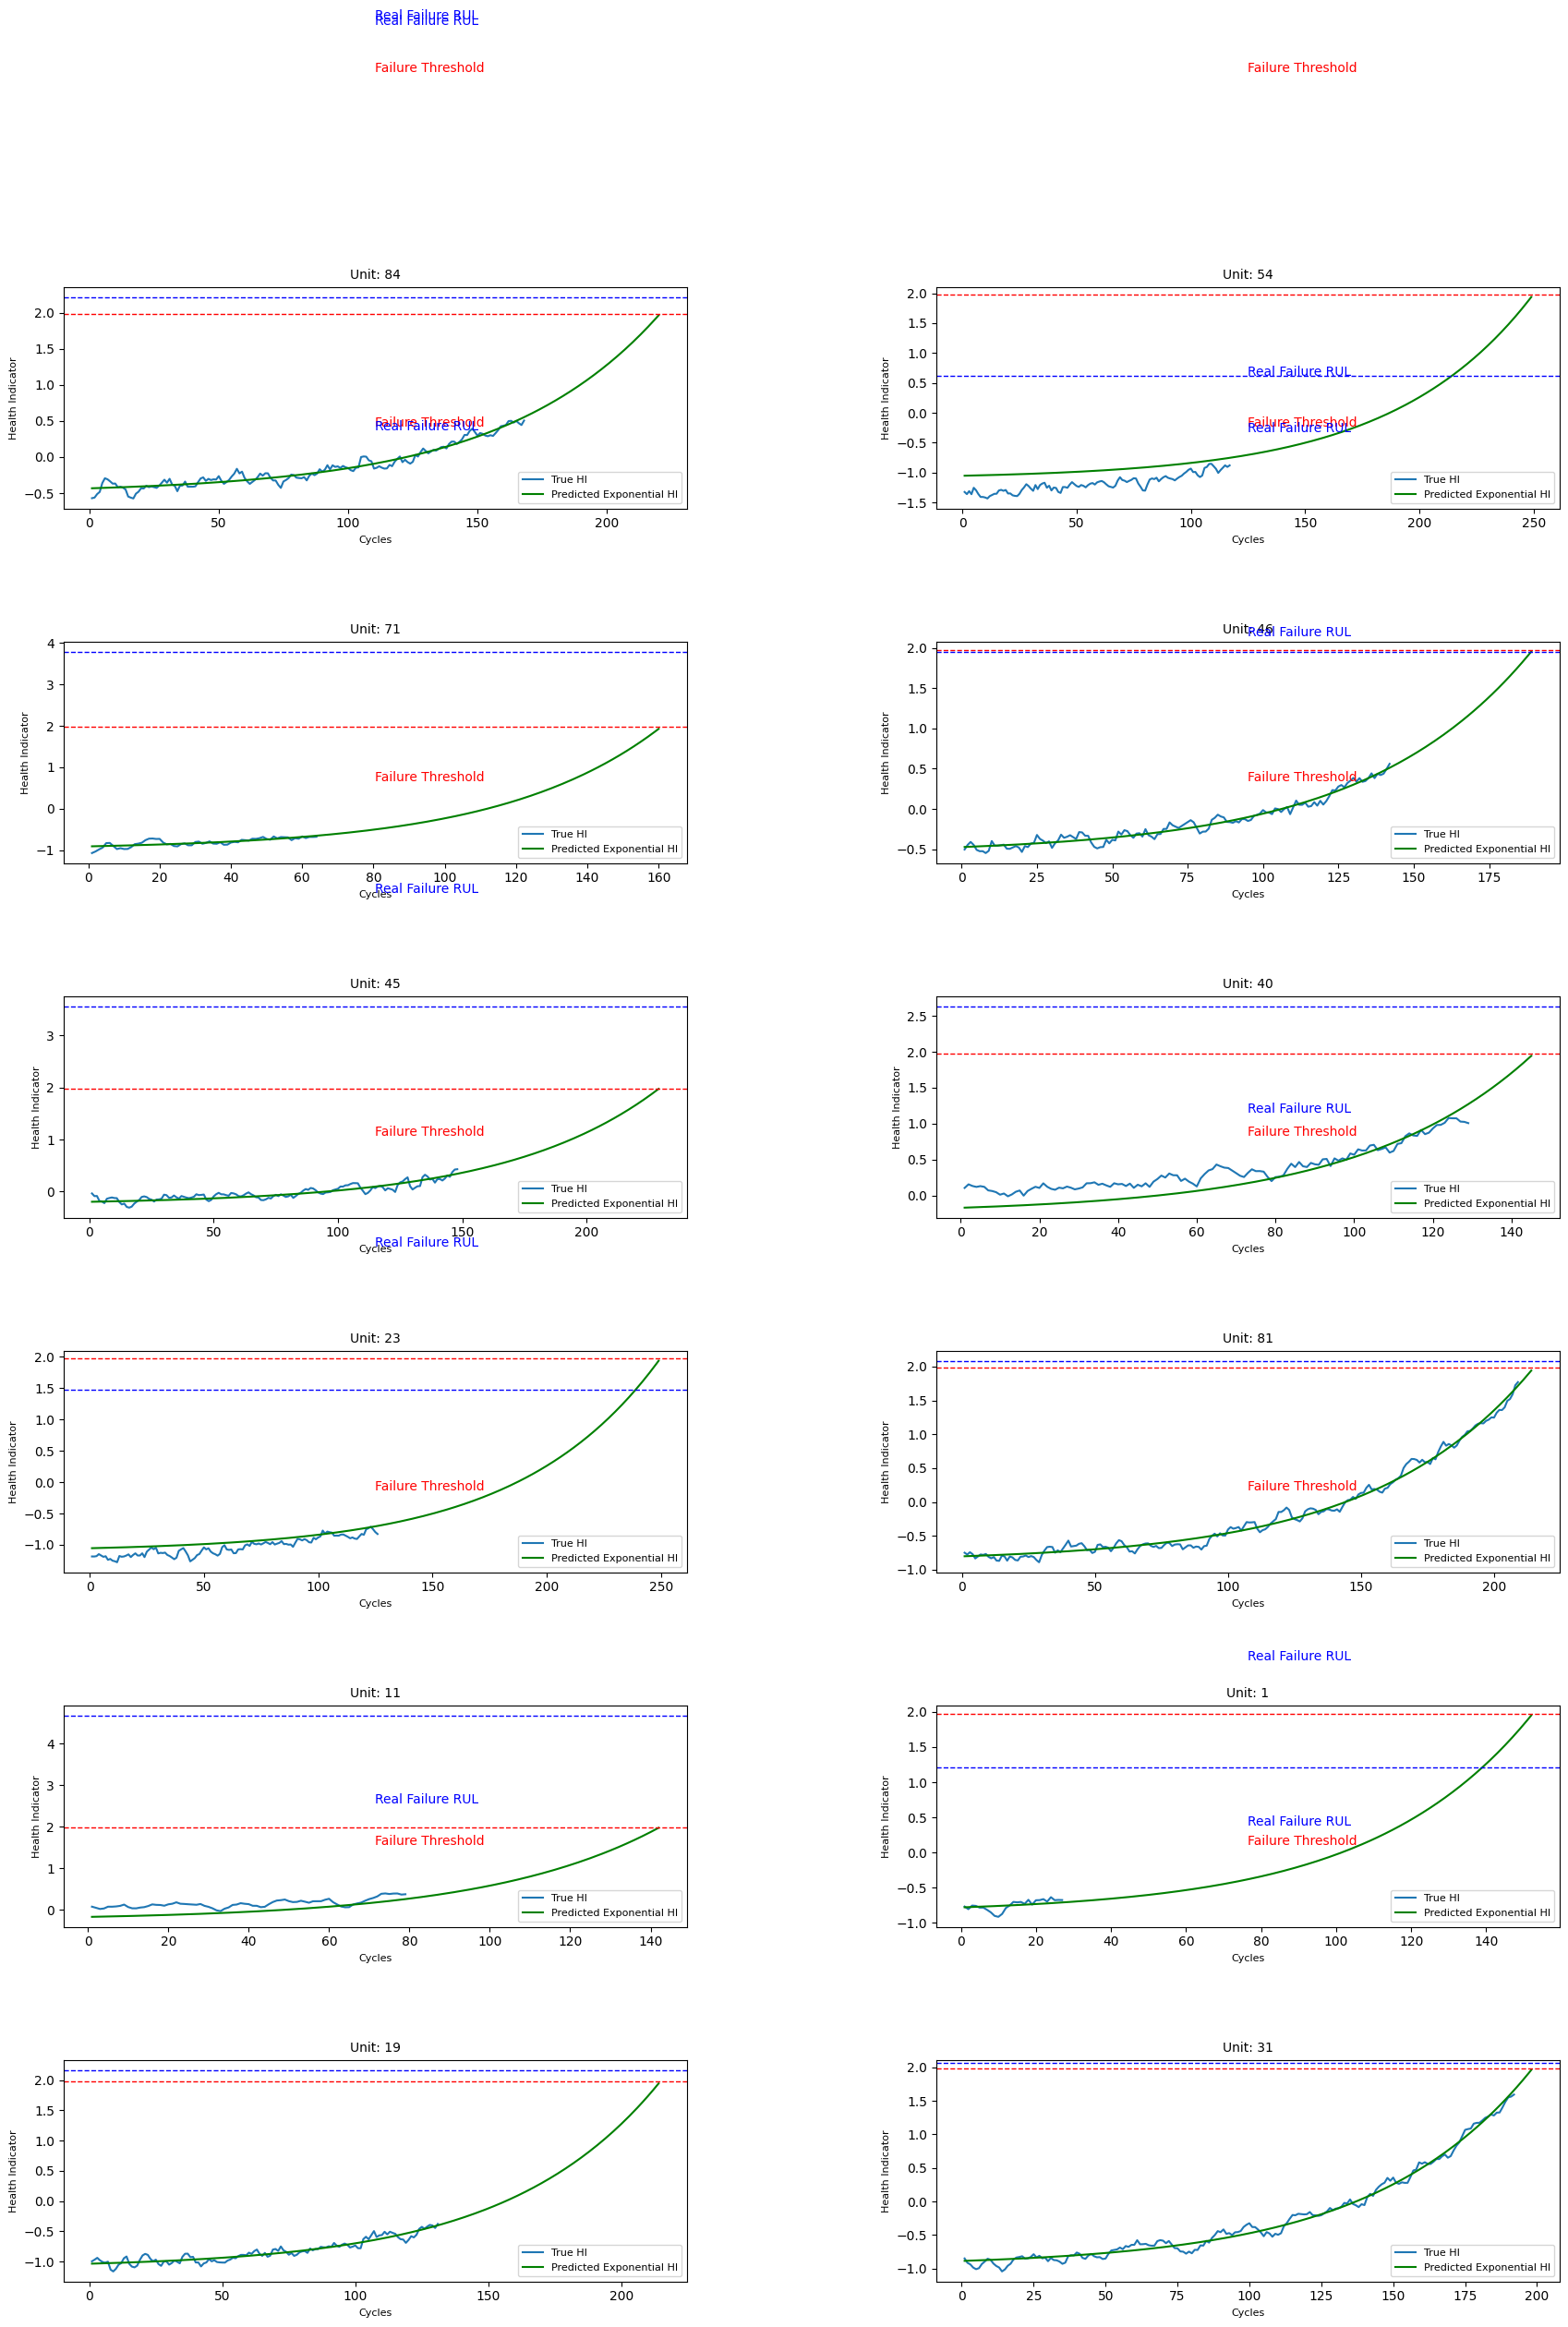

In [37]:

# Sélectionner 12 moteurs aléatoires
sample_engines = result_test_df['engine'].sample(12, random_state=42).values

# Tracer pour chaque moteur
fig, axs = plt.subplots(6, 2, figsize=(18, 24))  # Augmenter figsize pour plus d'espace
axs = axs.flatten()  # Pour faciliter l'accès aux sous-graphes

for i, engine_id in enumerate(sample_engines):
    ax = axs[i]  # Accéder à chaque sous-graphe
    
    # Récupérer les paramètres pour le moteur courant
    A = result_test_df.A[result_test_df.engine == engine_id].values[0]
    B = result_test_df.B[result_test_df.engine == engine_id].values[0]
    lambda_ = result_test_df.lambda_[result_test_df.engine == engine_id].values[0]
    Pred_RUL = int(result_test_df.Pred_RUL[result_test_df.engine == engine_id].values[0])
    
    # Récupérer le RUL réel pour le moteur actuel
    Reel_RUL = np.float64(test_rul.RUL[test_rul['engine'] == engine_id].values[0])

    # Récupérer les cycles et les données de l'indicateur de santé pour le moteur courant
    cycles = pca_test_df.time[pca_test_df.engine == engine_id]
    total_cycles = np.array([j for j in range(1, int(cycles.max() + Pred_RUL + 1))])  # Convertir en array numpy
    ht = pca_test_df.pc1[pca_test_df.engine == engine_id]

    # Calculer la dégradation ajustée pour ce moteur
    pred_ht = exp_degradation([A, B, lambda_], total_cycles)

    # Tracer les courbes de l'indicateur de santé
    sns.lineplot(data=pca_test_df[pca_test_df.engine == engine_id], x="time", y="pc1", ax=ax, label="True HI")
    sns.lineplot(y=pred_ht, x=total_cycles, ax=ax, color="green", label="Predicted Exponential HI")

    # Ajouter le seuil de défaillance
    ax.axhline(threshold, color='r', linestyle='--', linewidth=1)
    ax.text(0.5, threshold - 0.01, 'Failure Threshold', rotation=0, color='red', transform=ax.transAxes)

    # Ajouter le RUL réel
    ax.axhline(exp_degradation([A, B, lambda_],cycles.max()+Reel_RUL), color='blue', linestyle='--', linewidth=1)
    ax.text(0.5, exp_degradation([A, B, lambda_],cycles.max()+Reel_RUL) - 0.01, 'Real Failure RUL', rotation=0, color='blue', transform=ax.transAxes)

    # Ajouter des titres et des labels avec des tailles ajustées
    ax.set_title(f"Unit: {engine_id}", fontsize=10)
    ax.set_xlabel("Cycles", fontsize=8)
    ax.set_ylabel("Health Indicator", fontsize=8)
    ax.legend(fontsize=8)

# Ajuster manuellement les marges et l'espacement
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

# Afficher les graphes
plt.show()


Text(0, 0.5, 'True RUL')

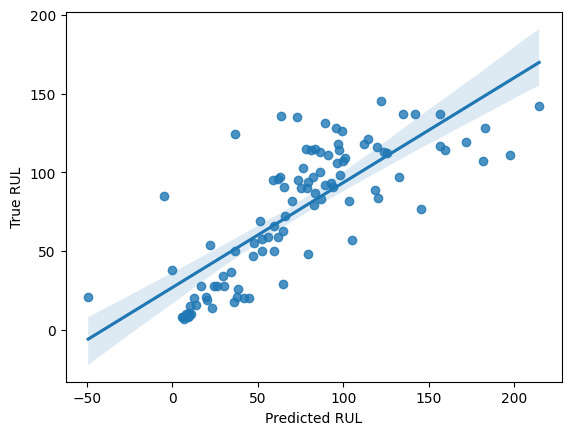

In [38]:
# Convertir les colonnes en types numériques si nécessaire
result_test_df['Pred_RUL'] = pd.to_numeric(result_test_df['Pred_RUL'], errors='coerce')
result_test_df['True_RUL'] = pd.to_numeric(result_test_df['True_RUL'], errors='coerce')

sns.regplot(x = result_test_df.Pred_RUL, y = result_test_df.True_RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

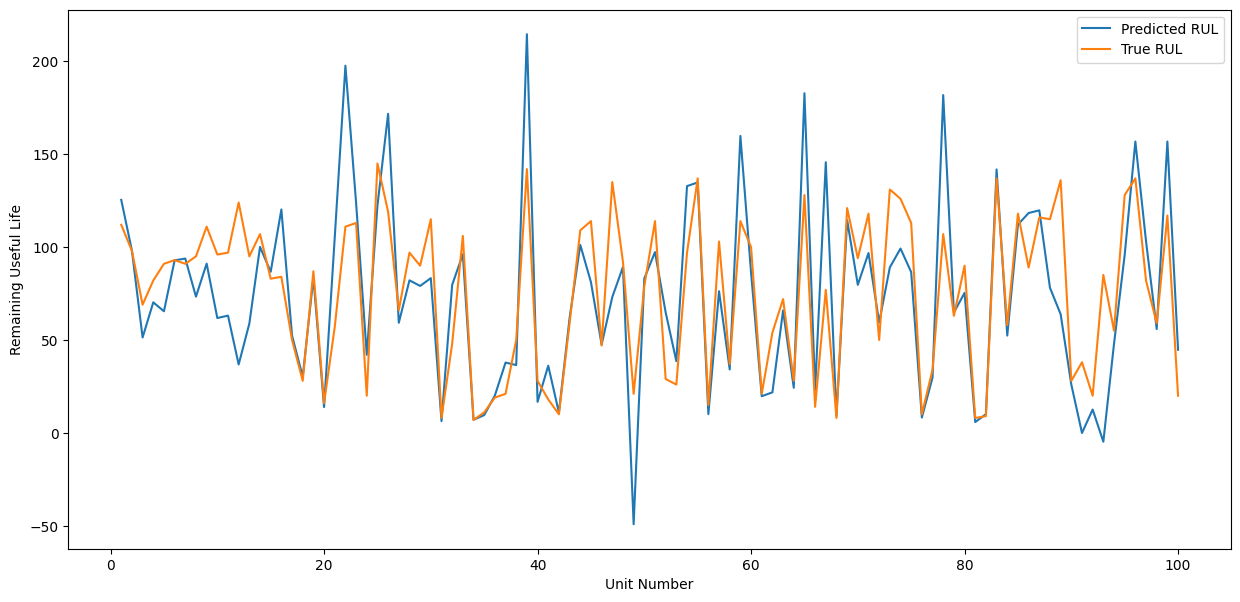

In [39]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = result_test_df.engine, y = result_test_df.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = result_test_df.engine, y = result_test_df.True_RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score, root_mean_squared_error

In [44]:
rmse=root_mean_squared_error(result_test_df.True_RUL, result_test_df.Pred_RUL)
rmse

np.float64(30.511424049085765)

In [42]:
mae=mean_absolute_error(result_test_df.True_RUL, result_test_df.Pred_RUL)
mae

np.float64(20.955430843915774)

In [43]:
r_2=r2_score(result_test_df.True_RUL, result_test_df.Pred_RUL)
r_2

0.460904866526616